In [1]:
from torchvision import models, transforms
from torch.autograd import Variable
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from PIL import Image
import torch.nn as nn
import numpy as np

In [2]:
import json
idx2label = []
cls2label = {}
cls2idx = {}
with open("../../data/imagenet_class_index.json", "r") as read_file:
    class_idx = json.load(read_file)
    idx2label = [class_idx[str(k)][1] for k in range(len(class_idx))]
    cls2label = {class_idx[str(k)][0]: class_idx[str(k)][1] for k in range(len(class_idx))}
    cls2idx = {class_idx[str(k)][0]: k for k in range(len(class_idx))}    
#print(idx2label)
#print(cls2label)
# cls2idx

In [3]:
model = models.resnet50(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to C:\Users\shitals/.torch\models\resnet50-19c8e357.pth
100%|██████████████████████████████████| 102502400/102502400 [00:12<00:00, 7919476.17it/s]


In [4]:
def get_image(path):
    with open(path, 'rb') as f:
        with Image.open(f) as img:
            return img.convert('RGB')       

In [65]:
def img2tensor(image):
    transf = get_input_transform()
    image = transf(image)
    return Variable(image.unsqueeze(0), requires_grad=False)

def class2tensor(target_class):
    return torch.LongTensor([target_class])

def get_input():
    #raw_input = get_image('D:/datasets/ImageNet/train/n02410509/n02410509_123.JPEG') #'bison'
    raw_input = get_image('D:/GitHubSrc/tensorwatch/data/cat.jpg')
    input = img2tensor(raw_input)
    target_class = class2tensor(14)
    return raw_input, input, target_class 

def get_pil_transform(): 
    transf = transforms.Compose([
        transforms.Scale(256),
        transforms.CenterCrop(224)
    ])    

    return transf

def get_preprocess_transform():
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])     
    transf = transforms.Compose([
        transforms.ToTensor(),
        normalize
    ])    

    return transf    


def get_input_transform():
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])       
    transf = transforms.Compose([
        transforms.Scale(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        normalize
    ])    

    return transf

#transf = get_input_transform() 
pill_transf = get_pil_transform()
preprocess_transform = get_preprocess_transform()

C:\ProgramData\Anaconda3\lib\site-packages\torchvision\transforms\transforms.py:188: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  "please use transforms.Resize instead.")


In [6]:
cls2label['n02410509']
cls2idx['n02410509']

347

In [66]:
raw_input, input, target_class = get_input()

C:\ProgramData\Anaconda3\lib\site-packages\torchvision\transforms\transforms.py:188: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  "please use transforms.Resize instead.")


In [67]:
model.eval() # without this you will have wrong predictions for resnet
logits = model(input)
probs = F.softmax(logits, dim=1)
probs5 = probs.topk(5)
[(p,c, idx2label[c]) for p, c in zip(probs5[0][0].detach().numpy(), probs5[1][0].detach().numpy())]
#probs.detach()[0].numpy()

[(0.27954495, 285, 'Egyptian_cat'),
 (0.27564916, 281, 'tabby'),
 (0.08283327, 287, 'lynx'),
 (0.079159774, 283, 'Persian_cat'),
 (0.055518255, 282, 'tiger_cat')]

In [9]:
def predict_fn(img):
    model.eval()    
    input = img2tensor(raw_input)
    logits = model(input)
    probs = F.softmax(logits, dim=1)   
    return probs.detach()[0].numpy()

def batch_predict(images):
    batch = torch.stack(tuple(preprocess_transform(i) for i in images), dim=0)
    logits = model(batch)
    probs = F.softmax(logits, dim=1)
    return probs.detach().numpy()

In [10]:
# raw_images = [raw_input, raw_input]
# raw_images_sized = [pill_transf(i) for i in raw_images]

In [68]:
a = batch_predict([pill_transf(raw_input)])
a.squeeze().argmax()

285

In [12]:
from lime import lime_image

In [69]:
explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(np.array(pill_transf(raw_input)), batch_predict, top_labels=8, num_samples=1000)

In [17]:
from skimage.segmentation import mark_boundaries

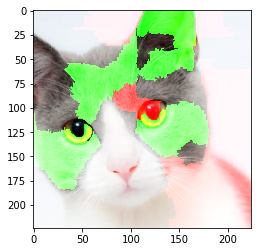

In [72]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
img = mark_boundaries(temp/255.0, mask)
plt.imshow(temp/255.0)

In [27]:
explanation.top_labels[0]

347